Libraries & Parameters

In [64]:
!pip install -q awswrangler

import awswrangler as wr
import pandas as pd

import boto3
import pytz

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import datetime
from sagemaker import get_execution_role

import warnings, scipy 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec

from scipy.optimize import curve_fit
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict


plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
warnings.filterwarnings("ignore")
%matplotlib inline

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [2]:
# Get Sagemaker Role
role = get_execution_role()
print(role)

Couldn't call 'get_role' to get Role ARN from role name AmazonSageMaker-ExecutionRole-20210503T205912 to get Role path.
Assuming role was created in SageMaker AWS console, as the name contains `AmazonSageMaker-ExecutionRole`. Defaulting to Role ARN with service-role in path. If this Role ARN is incorrect, please add IAM read permissions to your role or supply the Role Arn directly.


arn:aws:iam::506926764659:role/service-role/AmazonSageMaker-ExecutionRole-20210503T205912


___
# 1.) Download Data

## S3 parameters

In [3]:
# Flight data from Sagemaker Data Wrangler
bucket = 'sagemaker-us-west-2-506926764659/export-flow-05-16-30-08-0c003aed/output/data-wrangler-flow-processing-05-16-30-08-0c003aed/b98f4f8c-ddaf-4ee1-99da-b0dd09f47a21/default'
filename = 'part-00000-92fade68-00c4-41b3-9182-593084da2eae-c000.csv'
path_to_file = 's3://{}/{}'.format(bucket, filename)

# # Flight data from entire year of 2011
# bucket = 'from-public-data/carrier-perf/transformed'
# filename = 'airOT2011all.csv'
# path_to_file = 's3://{}/{}'.format(bucket, filename)

# # Flight data from 2011_01 
# bucket = 'from-public-data/carrier-perf/transformed/airOT2011'
# filename = 'airOT201101.csv'
# path_to_file = 's3://{}/{}'.format(bucket, filename)


# ________________________________________________________________
# Supporting dataset useful for EDA and understanding data
#   - airport codes
#   - airline codes
bucket2 = 'from-public-data/carrier-perf/raw'
file_airport = 'airports.csv'
file_airline = 'airlines.csv'

path_to_file_airport = 's3://{}/{}'.format(bucket2, file_airport)
path_to_file_airline = 's3://{}/{}'.format(bucket2, file_airline)

=== === === === ===
## Download data from S3

### 1. Flights Performance dataset

In [4]:
df = wr.s3.read_csv([path_to_file])
df

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,ORIGIN_AIRPORT_ID,ORIGIN,DEST_AIRPORT_ID,DEST,DEP_TIME,DEP_DELAY,ACTUAL_ELAPSED_TIME,ARR_TIME,ARR_DELAY,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,late_flight,DEP_DELAY_no_outlier
0,2007,1,1,1,9E,11278,DCA,11986,GRR,2044.0,44.0,138.0,2302.0,70.0,95.0,524.0,0.0,0.0,26.0,0.0,44.0,late,44
1,2007,1,1,1,9E,13487,MSP,11003,CID,1939.0,7.0,132.0,2151.0,75.0,39.0,221.0,7.0,0.0,68.0,0.0,0.0,late,7
2,2007,1,1,1,9E,13487,MSP,11637,FAR,913.0,-2.0,56.0,1009.0,-19.0,39.0,223.0,NaN,NaN,NaN,NaN,NaN,late,-2
3,2007,1,1,1,9E,13487,MSP,10469,AZO,2122.0,57.0,88.0,2350.0,53.0,55.0,426.0,53.0,0.0,0.0,0.0,0.0,late,57
4,2007,1,1,1,9E,13487,MSP,11298,DFW,1410.0,10.0,138.0,1628.0,-7.0,123.0,852.0,NaN,NaN,NaN,NaN,NaN,late,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7294644,2007,12,31,1,YV,16218,YUM,14107,PHX,750.0,-10.0,65.0,855.0,-12.0,38.0,160.0,NaN,NaN,NaN,NaN,NaN,late,-10
7294645,2007,12,31,1,YV,16218,YUM,14107,PHX,1220.0,-14.0,54.0,1314.0,-12.0,33.0,160.0,NaN,NaN,NaN,NaN,NaN,late,-14
7294646,2007,12,31,1,YV,16218,YUM,14107,PHX,1600.0,-5.0,58.0,1658.0,-2.0,33.0,160.0,NaN,NaN,NaN,NaN,NaN,late,-5
7294647,2007,12,31,1,YV,16218,YUM,14107,PHX,900.0,-30.0,74.0,1014.0,-10.0,31.0,160.0,NaN,NaN,NaN,NaN,NaN,late,-30


A whopping 7,294,649 rows (records) of JUST year 2007!  Thanks to all the Sagemaker Data Wrangler, I was able to already do some data cleaning and adjustment:
  - Create new variable `late_flight` depending on `DEP_DELAY`
  - Trim value to remove outliers for `DEP_DLAY`
  - Drop records for Cancelled flights `CANCELED` == 1 (doesn't make much sense to have flights that's irrelevant to flights delay when flight never occur)

### 2. Airports & Airlines dataset

In [5]:
df_airports = wr.s3.read_csv([path_to_file_airport])
df_airlines = wr.s3.read_csv([path_to_file_airline])
# df_airlines

=== === === === ===
## Initial Data Clean-up and Organization

In [6]:
# rename 'DAY_OF_MONTH' column to 'DAY' (in prep of transforming to datetime format)
df = df.rename(columns={'DAY_OF_MONTH': 'DAY'})
# df

### 1. Date / Time modifications

Make date and time more appropriate.  This will make it easier when making plots.

In [7]:
# Create a datetime field `DATE`
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH','DAY']])

In [8]:
# Convert 'HHMM' string to datetime.time
def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure

In [9]:
df['DEP_TIME'] = df['DEP_TIME'].apply(format_heure)
df['ARR_TIME'] = df['ARR_TIME'].apply(format_heure)

### 2. Organize Columns

Let's organize columns (features) to be more logical

In [10]:
variables_to_remove = ['ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID']
df.drop(variables_to_remove, axis = 1, inplace = True)

df = df[[
    'DATE',
    'YEAR',
    'MONTH',
    'DAY',
    'DAY_OF_WEEK',
    'UNIQUE_CARRIER',
    'ORIGIN',
    'DEST',
    'DEP_TIME',
    'DEP_DELAY',
    'DEP_DELAY_no_outlier',
    'ACTUAL_ELAPSED_TIME',
    'AIR_TIME',
    'DISTANCE',
    'ARR_TIME',
    'ARR_DELAY',
    'CARRIER_DELAY',
    'WEATHER_DELAY',
    'NAS_DELAY',
    'SECURITY_DELAY',
    'LATE_AIRCRAFT_DELAY',
    'late_flight']]

In [11]:
df

,DATE,YEAR,MONTH,DAY,DAY_OF_WEEK,UNIQUE_CARRIER,ORIGIN,DEST,DEP_TIME,DEP_DELAY,DEP_DELAY_no_outlier,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,ARR_TIME,ARR_DELAY,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,late_flight
0,2007-01-01,2007,1,1,1,9E,DCA,GRR,20:44:00,44.0,44,138.0,95.0,524.0,23:02:00,70.0,0.0,0.0,26.0,0.0,44.0,late
1,2007-01-01,2007,1,1,1,9E,MSP,CID,19:39:00,7.0,7,132.0,39.0,221.0,21:51:00,75.0,7.0,0.0,68.0,0.0,0.0,late
2,2007-01-01,2007,1,1,1,9E,MSP,FAR,09:13:00,-2.0,-2,56.0,39.0,223.0,10:09:00,-19.0,NaN,NaN,NaN,NaN,NaN,late
3,2007-01-01,2007,1,1,1,9E,MSP,AZO,21:22:00,57.0,57,88.0,55.0,426.0,23:50:00,53.0,53.0,0.0,0.0,0.0,0.0,late
4,2007-01-01,2007,1,1,1,9E,MSP,DFW,14:10:00,10.0,10,138.0,123.0,852.0,16:28:00,-7.0,NaN,NaN,NaN,NaN,NaN,late
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7294644,2007-12-31,2007,12,31,1,YV,YUM,PHX,07:50:00,-10.0,-10,65.0,38.0,160.0,08:55:00,-12.0,NaN,NaN,NaN,NaN,NaN,late
7294645,2007-12-31,2007,12,31,1,YV,YUM,PHX,12:20:00,-14.0,-14,54.0,33.0,160.0,13:14:00,-12.0,NaN,NaN,NaN,NaN,NaN,late
7294646,2007-12-31,2007,12,31,1,YV,YUM,PHX,16:00:00,-5.0,-5,58.0,33.0,160.0,16:58:00,-2.0,NaN,NaN,NaN,NaN,NaN,late
7294647,2007-12-31,2007,12,31,1,YV,YUM,PHX,09:00:00,-30.0,-30,74.0,31.0,160.0,10:14:00,-10.0,NaN,NaN,NaN,NaN,NaN,late


___
# 2.) Explorational Data Analysis

Let's take a look at the entire year of 2007 flight data... We begin by checking for _NULL_ values from the whopping **7.3M records**.

Based on the original dataset provided, I decided to select relevant attributes.  For example:

  - Selected variables with potentially high correlations, thereby minimize chance of over-fitting
  - Drop rows where flights were Cancelled.  Because if a flight is canceled, it's irrelevant to topic of **Delay**.

Let's make sure our dataset contains data from year 2007, at least we hope...

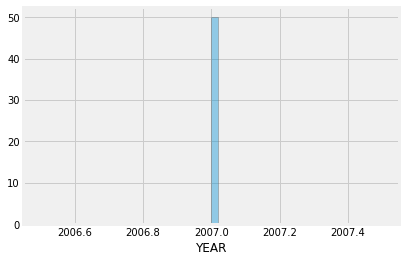

In [12]:
sns.distplot(df['YEAR'])

Sure enough, there's only year 2007 data

#### Bastic Statistics of Dataset

In [14]:
# percentile list
perc =[.20, .40, .60, .80]
df.describe(percentiles = perc).round(2)

# REF. https://www.geeksforgeeks.org/python-pandas-dataframe-describe-method/

,YEAR,MONTH,DAY,DAY_OF_WEEK,DEP_DELAY,DEP_DELAY_no_outlier,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,ARR_DELAY,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
count,7294649.0,7294649.00,7294649.00,7294649.00,7294649.00,7294649.00,7277467.00,7277467.00,7294649.0,7277467.00,1804028.00,1804028.00,1804028.00,1804028.0,1804028.00
mean,2007.0,6.53,15.73,3.94,11.40,10.53,126.32,102.81,722.9,10.19,15.98,3.18,15.64,0.1,21.07
std,0.0,3.42,8.79,1.99,36.14,29.41,70.15,67.07,564.0,39.31,40.03,19.36,29.93,2.2,39.17
min,2007.0,1.00,1.00,1.00,-305.00,-133.00,12.00,0.00,11.0,-312.00,0.00,0.00,0.00,0.0,0.00
20%,2007.0,3.00,7.00,2.00,-5.00,-5.00,70.00,50.00,280.0,-11.00,0.00,0.00,0.00,0.0,0.00
40%,2007.0,5.00,13.00,3.00,-2.00,-2.00,94.00,71.00,447.0,-4.00,0.00,0.00,0.00,0.0,0.00
50%,2007.0,7.00,16.00,4.00,0.00,0.00,108.00,84.00,573.0,0.00,0.00,0.00,4.00,0.0,0.00
60%,2007.0,8.00,19.00,5.00,1.00,1.00,125.00,100.00,679.0,4.00,5.00,0.00,10.00,0.0,11.00
80%,2007.0,10.00,25.00,6.00,16.00,16.00,170.00,144.00,1044.0,20.00,23.00,0.00,23.00,0.0,35.00
max,2007.0,12.00,31.00,7.00,2601.00,155.00,1270.00,1257.00,4962.0,2598.00,2580.00,1429.00,1386.00,382.0,1031.00


Between the various delay types, `CARRIER_DELAY` and Late `LATE_AIRCRAFT_DELAY` related delay have widest spread (approx. std-dev == 40).  Therefore, an area worth investigating is to see if these delays are cause my airline's logistics (something airline can control) or traffic pattern (something airline might not be able to control).

#### Delays by Airlines
Let see how punctual airlines are back in year 2007

In [15]:
# Basic Stats functions
def get_stats(group):
    return {'min': group.min(), 'max': group.max(), 'count': group.count(), 'mean': group.mean()}

#_______________________________________________________________
# Creation of a dataframe with statitical infos on each airline:
global_stats = df['DEP_DELAY'].groupby(df['UNIQUE_CARRIER']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,min,max,count,mean
UNIQUE_CARRIER,,,,
KH,-82.0,624.0,45972.0,0.438702
HA,-169.0,1317.0,55937.0,-0.882958
F9,-90.0,887.0,97362.0,7.411115
AS,-305.0,819.0,157622.0,10.733889
B6,-62.0,1048.0,187740.0,14.739054
OH,-39.0,966.0,227120.0,12.623252
9E,-47.0,1956.0,250912.0,9.109935
FL,-34.0,869.0,260557.0,9.035036
EV,-165.0,1002.0,277314.0,20.220919


#### Delays Differences by Airlines // by its Origin // over the day

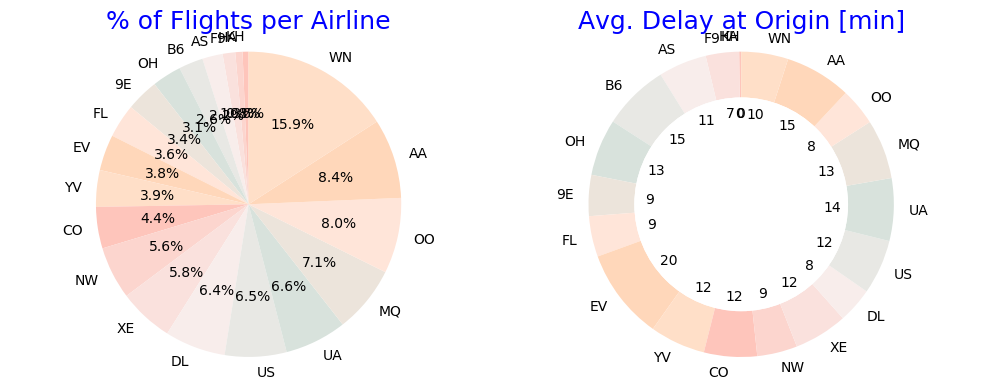

In [59]:
# Figures Configurations 
fig = plt.figure(1, figsize=(10,4))
gs = GridSpec(1,2)
ax1 = fig.add_subplot(gs[0,0]) 
ax2 = fig.add_subplot(gs[0,1]) 
# ax3 = fig.add_subplot(gs[1,:])

# colors
colors = ['#FEC5BB', '#FCD5CE', '#FAE1DD', '#F8EDEB', '#E8E8E4', '#D8E2DC', '#ECE4DB', '#FFE5D9', '#FFD7BA', '#FFDFC8']



# ________________________________________________________________________________________________
# Pie Chart (left) | Pctg of Airlines in Operation during 2007

labels = [i for i in global_stats.index]
sizes = global_stats['count'].values

patches, texts, autotexts = ax1.pie(sizes, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90)

for text in texts:
    text.set_color('black')

for autotext in autotexts:
    autotext.set_color('black')

    
# draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

    
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.set_title('% of Flights per Airline', color='b', fontsize=18)
ax1.axis('equal')  



# ________________________________________________________________________________________________
# Pie Chart (right) | Avg. Flight Delay at Origin

labels = [i for i in global_stats.index]
sizes  = global_stats['mean'].values
sizes  = [max(s,0) for s in sizes]
# explode = [0.0 if sizes[i] < 20000 else 0.01 for i in range(len(df_airlines))]

patches, texts, autotexts = ax2.pie(sizes, colors=colors, labels=labels, autopct = lambda p :  '{:.0f}'.format(p * sum(sizes) / 100), startangle=90)


for text in texts:
    text.set_color('black')

for autotext in autotexts:
    autotext.set_color('black')

    
# draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

    
# Equal aspect ratio ensures that pie is drawn as a circle
ax2.set_title('Avg. Delay at Origin [min]', color='b', fontsize=18)
ax2.axis('equal')



# ________________________________________________________________________________________________
plt.tight_layout()
plt.show()

The left pie-chart suggests that the top-3 volume of flights by airlines are:
  1. Southwest Airlines (WN)      -- 15.9%
  1. American Airlines (AA)       --  8.4%
  1. Continental Airlines (CO)    --  8.0%
  
Interestingly, the right pie-chart would suggests that the delays are relatively uniform across airlines (approx. 10-min.)

#### Delay Difference between Departure and Arrival?

KeyError: '9E'

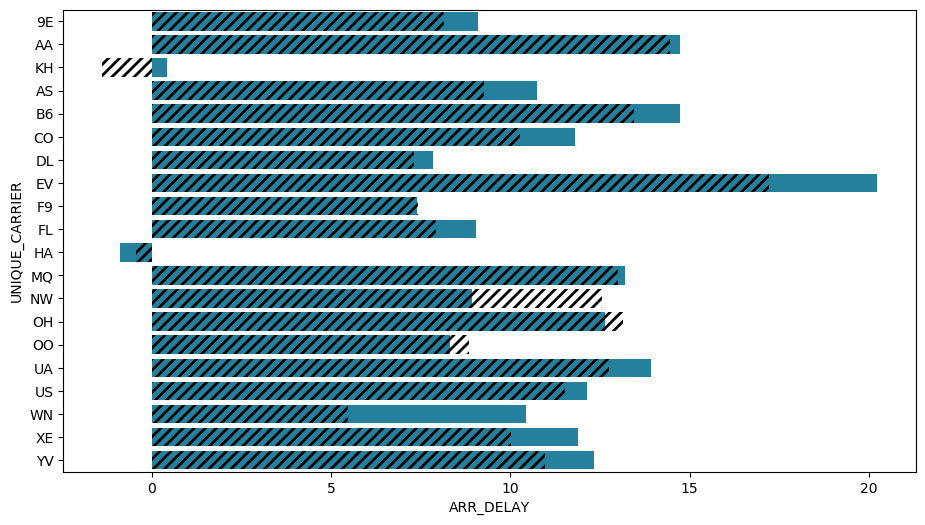

In [61]:
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['hatch.linewidth'] = 2.0  

fig = plt.figure(1, figsize=(11,6))
ax = sns.barplot(x="DEP_DELAY", y="UNIQUE_CARRIER", data=df, color="#118ab2", ci=None)
ax = sns.barplot(x="ARR_DELAY", y="UNIQUE_CARRIER", data=df, color="#faedcd", hatch = '///', alpha=0.0, ci=None)

labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
ax.yaxis.label.set_visible(False)
plt.xlabel('Avg. Delay [min] (@departure: Blue, @arrival: Hashes)', fontsize=14, weight = 'bold', labelpad=10);

Illustration above suggests that Arrival Delay (hashes) are generally small than Departure Delay (blue).  Perhaps airlines (pilots) can make up time by flying more efficiently (e.g., route, speed); in other word, airline have greater control of reducing a delay in general by reducing flight time.

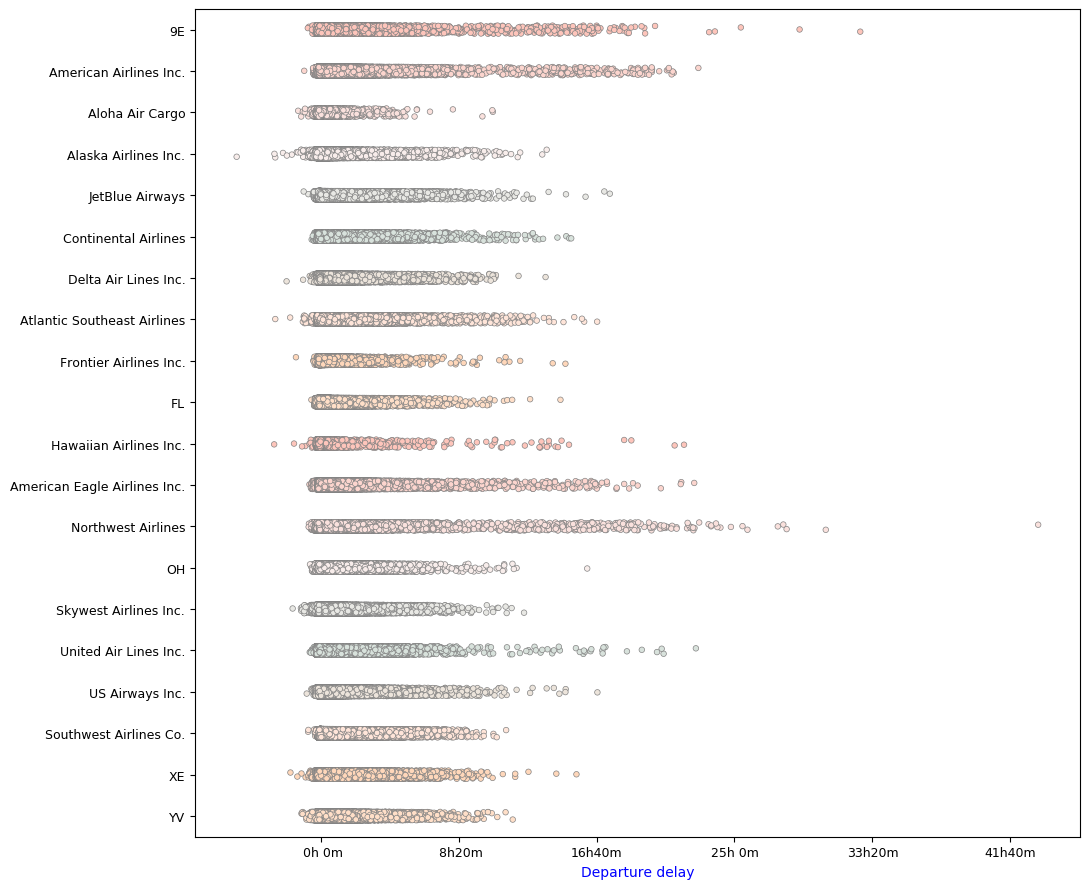

In [58]:
# Figures Configurations 
fig = plt.figure(1, figsize=(11,9))
gs = GridSpec(1,1)
ax3 = fig.add_subplot(gs[0, :])

# colors
colors = ['#FEC5BB', '#FCD5CE', '#FAE1DD', '#F8EDEB', '#E8E8E4', '#D8E2DC', '#ECE4DB', '#FFE5D9', '#FFD7BA', '#FFDFC8']



#___________________________________________________________________
# Flight Delays over time

# Airlines Code vs. Descriptive Name
abbr_companies = df_airlines.set_index('IATA_CODE')['AIRLINE'].to_dict()

df2 = df.loc[:, ['UNIQUE_CARRIER', 'DEP_DELAY']]
df2['UNIQUE_CARRIER'] = df2['UNIQUE_CARRIER'].replace(abbr_companies)

ax3 = sns.stripplot(y="UNIQUE_CARRIER", x="DEP_DELAY", size=4, palette=colors, data=df2, linewidth=0.5,  jitter=True)
plt.setp(ax3.get_xticklabels(), fontsize=9)
plt.setp(ax3.get_yticklabels(), fontsize=9)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                     for x in ax3.get_xticks()])
plt.xlabel('Departure delay', color='b')
ax3.yaxis.label.set_visible(False)


# ________________________________________________________________________________________________
plt.tight_layout()
plt.show()

The figure above illustrates the spread (dispersion) of delays during the year 2007, which interestingly juxtaposes with the Avg. Delay pie-chart above (right-hand pie-chart).  Note that while the Avg. Delay is about 10-min, one can see from above chart that most flights depart on-time or slightly ahead of schedule.

Perhaps a better method to upper-right pie-chart is to calculate the median value.

#### "Breadth" & "Depth"

At this point, I'm eager to start training a model to identify the top causes (features) to a delay, then ultimately create a generalized model that can predict if a flight will be delayed or not.  However, given the relatively large amount of data (even if it's a single year), I believe it's best to select with domain insights.

In this case, I'd like to create a generalize model with airline (data) that captures the breadth (various locations it flies between) and the depth (volume of flights).

In [35]:
# Origins
origin_nb = dict()
for carrier in abbr_companies.keys():
    liste_origin_airport = df[df['UNIQUE_CARRIER'] == carrier]['ORIGIN'].unique()
    origin_nb[carrier] = len(liste_origin_airport)
    
# origin_nb

{'UA': 85,
 'AA': 82,
 'US': 87,
 'F9': 51,
 'B6': 48,
 'OO': 154,
 'AS': 48,
 'NK': 0,
 'WN': 64,
 'DL': 105,
 'EV': 160,
 'HA': 14,
 'MQ': 118,
 'VX': 0,
 'CO': 86,
 'NW': 115,
 'KH': 11}

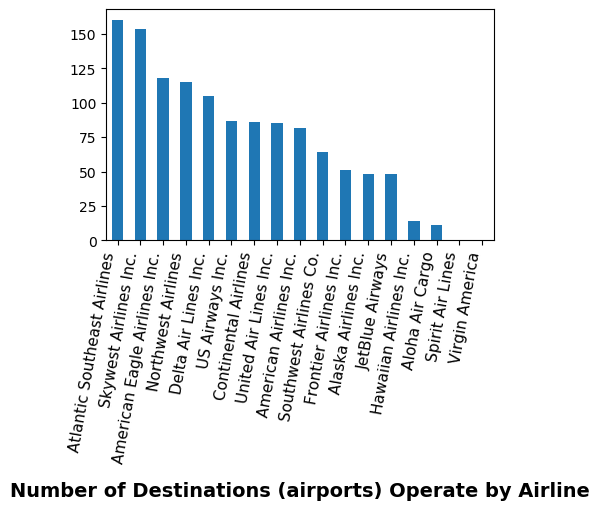

In [62]:
test_df = pd.DataFrame.from_dict(origin_nb, orient='index')
test_df.rename(columns = {0:'count'}, inplace = True)

test_df_sorted = test_df.sort_values('count',ascending=False)

ax = test_df_sorted.plot(kind='bar', figsize = (5,3))
labels = [abbr_companies[item.get_text()] for item in ax.get_xticklabels()]

ax.set_xticklabels(labels)
plt.xlabel('Number of Destinations (airports) Operate by Airline', fontsize=14, weight = 'bold', labelpad=12)
plt.setp(ax.get_xticklabels(), fontsize=11, ha = 'right', rotation = 80)
ax.legend().set_visible(False)
plt.show()

# ref. https://datavizpyr.com/bar-plots-with-matplotlib-in-python/
# ref. https://towardsdatascience.com/combo-charts-with-seaborn-and-python-2bc911a08950

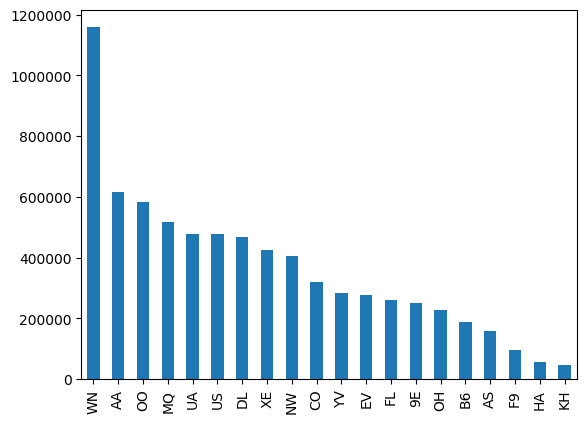

In [63]:
df['UNIQUE_CARRIER'].value_counts()[:20].plot(kind='bar')

Seems following airline:

* American Airline (AA)
* Skywest (OO)
* American Eagle (MQ)

all have  both breadth and depth.